# Background:

A local hospital has seen an increase in elderly patient falls. This has caused a significant increase in the hospitals operating costs. They are not sure why the falls are increasing and don't have a good way to prevent them. They have hired you as a data scientist to identify what the risk factors for people falling are. They also want a way to predict if a patient will fall or not for preventative care.

# Objective:

1. Identify risk factors that are associated with falling.
2. Predict which patients will fall, not fall, or stumble.

# Data Dictionary:
Link to dataset: https://www.kaggle.com/datasets/laavanya/elderly-fall-prediction-and-detection/data?select=cStick.csv
> Each row in the dataset represents one individual.

- Distance (cm): ? find out through EDA?

- Pressure: Monitors sudden changes in grasping pressure.

- HRV (BPM): Measures heart rate variability (HRV) in beats per minute (BPM).

- Blood Sugar Level (mg/dL): Monitors blood glucose level in milligram per deciliter

- SpO2: Monitors percent of blood oxygen saturation.

- Accelerometer: Monitors linear acceleration of the walking cane. If a +/- spike of 3-g is detected a threshold is set off to detect a fall. 0 means there was not a fall and 1 means there was a fall.

- Decision: 0 = no fall detected, 1 = stumble was detected, 2 = fall detected.

**Parameter Range for Thresholds:**

| Distance (cm) | Pressure | HRV (bpm) | Blood Sugar Level (mg/dL) | SpO2 (%) | Accelerometer | Decision
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  > 50   |   small   |  60-90    |      70-80    |  > 90  |  < threshold  |  no fall  |
|  < 30   |  medium   |  90-105   |      30-70    |  80-90  | > threshold  | stumbled  |
|  < 10   |   large   |  > 105    | < 30 or > 160 |  < 80  |  > threshold  |  fall  |

# Imports and Loading Data

In [2]:
## Imports
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
sns.set_style('darkgrid')

In [3]:
## Load data
df = pd.read_csv('Data/clean_fall_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 2039 non-null   int64  
 1   distance (cm)              2039 non-null   float64
 2   pressure                   2039 non-null   int64  
 3   hrv (bpm)                  2039 non-null   float64
 4   blood sugar level (mg/dL)  2039 non-null   float64
 5   spo2                       2039 non-null   float64
 6   accelerometer              2039 non-null   int64  
 7   decision                   2039 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 127.6 KB


,Unnamed: 0,distance (cm),pressure,hrv (bpm),blood sugar level (mg/dL),spo2,accelerometer,decision
0,0,25.540,1,101.396,61.080,87.770,1,1
1,1,2.595,2,110.190,20.207,65.190,1,2
2,2,68.067,0,87.412,79.345,99.345,0,0
3,3,13.090,1,92.266,36.180,81.545,1,1
4,4,69.430,0,89.480,80.000,99.990,0,0


In [4]:
## Remove 'Unnamed: 0' column
df = df.drop(columns='Unnamed: 0')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   distance (cm)              2039 non-null   float64
 1   pressure                   2039 non-null   int64  
 2   hrv (bpm)                  2039 non-null   float64
 3   blood sugar level (mg/dL)  2039 non-null   float64
 4   spo2                       2039 non-null   float64
 5   accelerometer              2039 non-null   int64  
 6   decision                   2039 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 111.6 KB


,distance (cm),pressure,hrv (bpm),blood sugar level (mg/dL),spo2,accelerometer,decision
0,25.540,1,101.396,61.080,87.770,1,1
1,2.595,2,110.190,20.207,65.190,1,2
2,68.067,0,87.412,79.345,99.345,0,0
3,13.090,1,92.266,36.180,81.545,1,1
4,69.430,0,89.480,80.000,99.990,0,0


# Functions

In [99]:
def plot_hist_boxplot(df, col, bins):
    """
    Plots a histogram and boxplot on the same x-axis for a specified
    dataframe column.
    
    Parameters:
    df: name of pandas dataframe.
    col (str): column name in pandas dataframe that will be plotted.
    bins (int): Adjusts number of bins in the histogram.
    """
    ## Subplots configuration
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True)
    
    ## Calculate the mean
    col_mean = df[col].mean()
    
    ## Calulate the median
    col_med = df[col].median()
    
    ## Histogram
    sns.histplot(data=df, x=col, bins=bins, kde=True, ax=ax[0])
    ax[0].lines[0].set_color('red')
    ax[0].axvline(col_mean, color='red', linestyle='--', label='Mean')
    ax[0].axvline(col_med, color='gray', label='Median')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('frequency')
    ax[0].legend()
        
    ## Boxplot
    sns.boxplot(data=df, x=df[col], ax=ax[1])
    ax[1].axvline(col_mean, color='red', linestyle='--')
        
    ## Show the plot
    plt.show();

In [100]:
def bar_plot(df, col):
    """
    Plots a bar plot showing the percentages of the target feature for each
    categorical feature
    """
    ## Barplots
    sns.barplot(x=df[col].value_counts().index, 
                y=df[col].value_counts(normalize=True) * 100)

# Understanding the Data

In [5]:
## Shape of the data
df.shape

(2039, 7)

> There are 2039 rows and 7 columns in the dataset.

In [6]:
## Statistical summary of the data
df.describe()

,distance (cm),pressure,hrv (bpm),blood sugar level (mg/dL),spo2,accelerometer,decision
count,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000
mean,28.694527,0.988720,95.657002,72.909243,83.563649,0.661599,0.988720
std,23.773644,0.815918,17.576499,46.940110,11.111592,0.473282,0.815918
min,0.000000,0.000000,60.000000,10.000000,60.000000,0.000000,0.000000
25%,7.642500,0.000000,82.418000,40.230000,75.285000,0.000000,0.000000
50%,20.560000,1.000000,97.238000,69.960000,85.280000,1.000000,1.000000
75%,55.205500,2.000000,109.695000,77.612500,92.692500,1.000000,2.000000
max,69.981000,2.000000,124.980000,179.293000,99.990000,1.000000,2.000000


- The pressure and decision columns only have values of 0, 1, 2, which is expected.

- The accelerometer column only has values of 0 and 1, which is expected.

- The minimum value for the distance column is 0 cm and the maximum value is 69.98 cm. It is still unclear what distance this feature is measuring. This will be explored during EDA.

- In the blood sugar level column there is a huge range between the 75th percentile and the max value. This will be explored further and adjusted if necessary.

- The minimum values for blood sugar levels and spo2 and both extremely low, to the point that in those conditions it would be considered a medical emergency.

# Univariate Analysis

## Continuous Features

### Distance (cm)

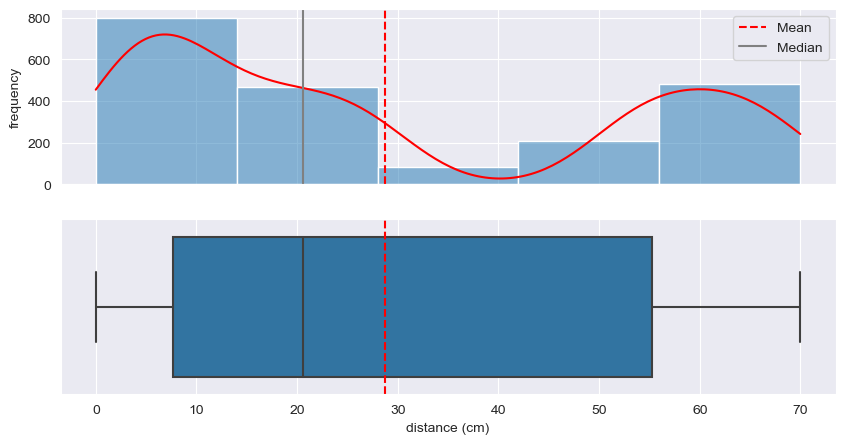

In [62]:
plot_hist_boxplot(df, 'distance (cm)', 5)

> - Resembles bimodal distribution with right skew.
> - Most of the distances are between 0 cm to 15 cm with another peak at the tail of the data between 55 cm to 70 cm.
> - The range of distances is quite spread (0 cm to 70 cm) and has two distinct groups at the low and high ranges of the distribution.

### HRV (bpm)

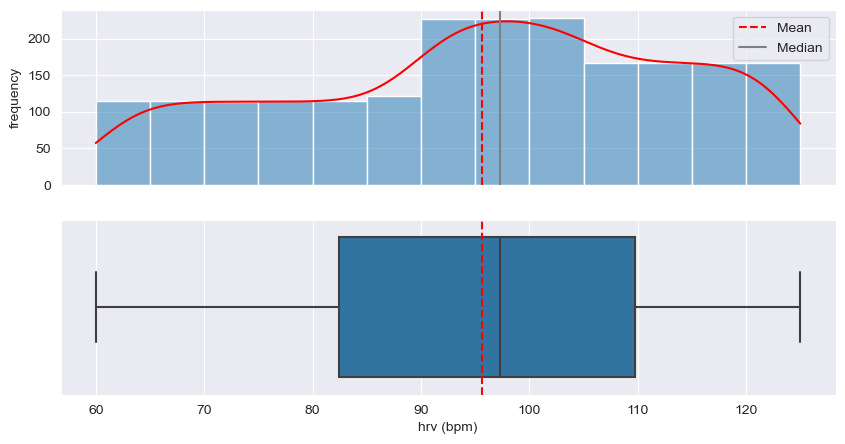

In [63]:
plot_hist_boxplot(df, 'hrv (bpm)', 13)

> - Resembles fairly uniform data with a peak around the middle of the distribution.
> - Most of the heart beat readings occur between 90 bpm to 105 bpm.
> - The mean and median are close which suggests a somewhat normal distribution.

### Blood Sugar Level (mg/dL)

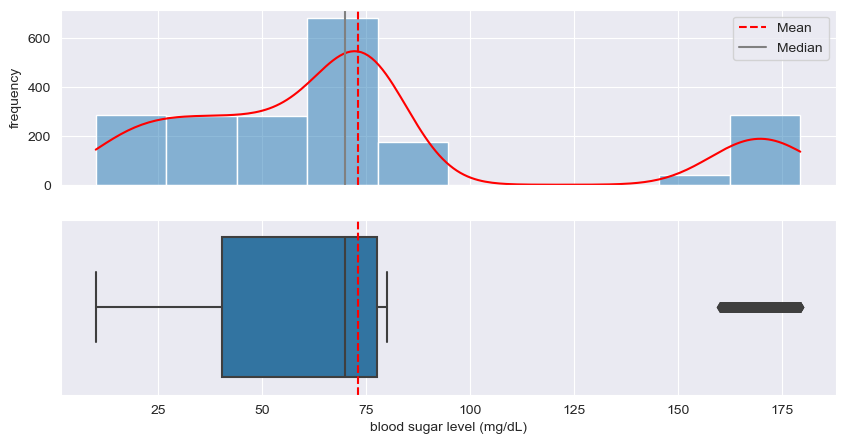

In [64]:
plot_hist_boxplot(df, 'blood sugar level (mg/dL)', 10)

> - Resembles bimodal distribution with significant outliers skewing the data to the right.
> - The proximity of the mean and median suggests the outliers are significant enough to make the data appear normal just looking at the mean and median.
> - There is a large peak ranging from approx. 60 mg/dL to 85 mg/dL.
> - The boxplot suggests that most of the data is distributed in the upper quartile ranges.

### SpO2

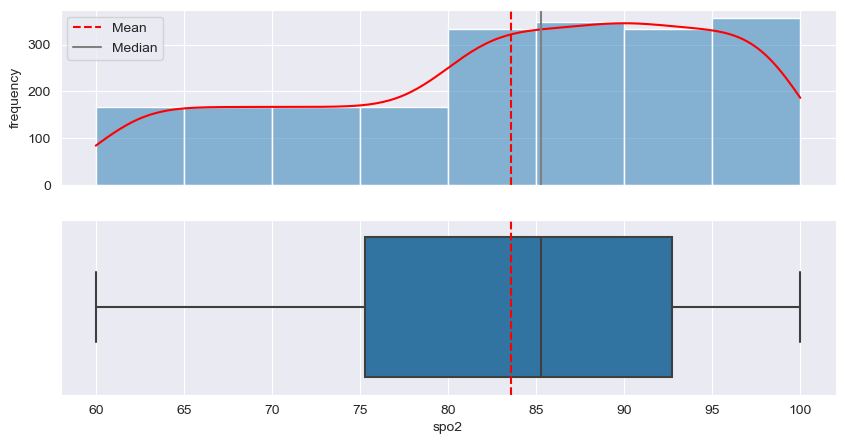

In [65]:
plot_hist_boxplot(df, 'spo2', 8)

> - Resembles relatively uniform distribution with left skew.
> - There seems to be two distinct groups. Group 1 ranges from 60% to 80% oxygen saturation. Group 2 ranges from 80% to 100% oxygen saturation.

## Categorical Features

### Pressure

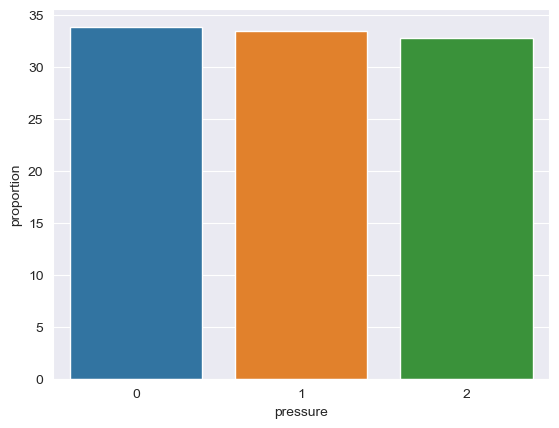

In [94]:
bar_plot(df, 'pressure')

In [97]:
## Evaluating target balance in pressure feature
df['pressure'].value_counts(normalize=True)

pressure
0    0.338401
1    0.334478
2    0.327121
Name: proportion, dtype: float64

### Accelerometer

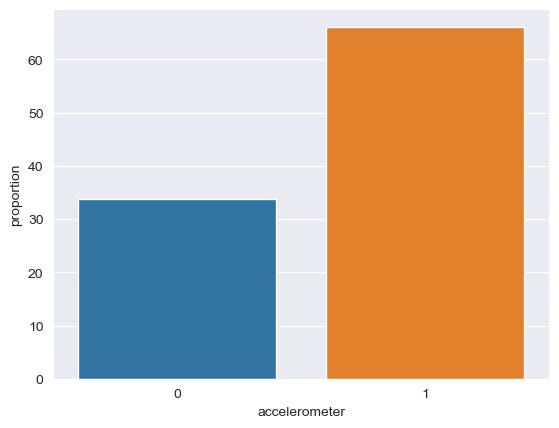

In [95]:
bar_plot(df, 'accelerometer')

In [98]:
## Evaluating target balance in accelerometer feature
df['accelerometer'].value_counts(normalize=True)

accelerometer
1    0.661599
0    0.338401
Name: proportion, dtype: float64

### Decision (Target)

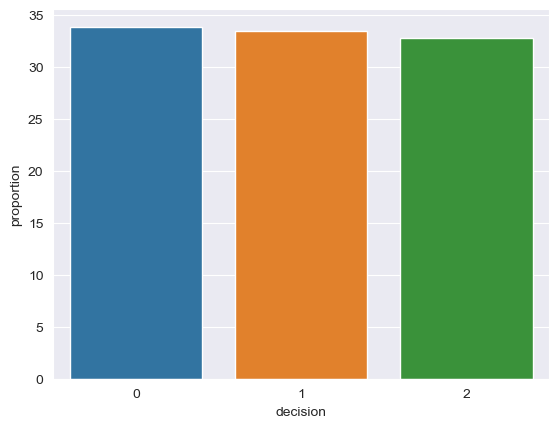

In [96]:
bar_plot(df, 'decision')

In [22]:
## Evaluating class balance in the target
df['decision'].value_counts(normalize=True)

decision
0    0.537802
2    0.255651
1    0.206547
Name: proportion, dtype: float64

# Bivariate Analysis

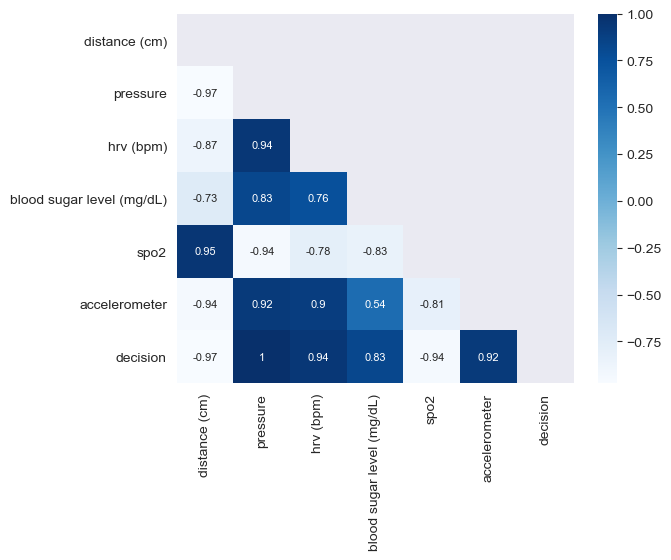

In [10]:
# Create correlation heatmap
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, cmap='Blues', annot=True, annot_kws={'size':8}, mask=mask)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

> - Many of the independent variables are highly correlated introducing multicollinearity into the data.
> - Distance (cm) and SpO2 are inversely correlated with the target.
> - Pressure is perfectly correlated with the target.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1283 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   distance (cm)              1283 non-null   float64
 1   pressure                   1283 non-null   int64  
 2   hrv (bpm)                  1283 non-null   float64
 3   blood sugar level (mg/dL)  1283 non-null   float64
 4   spo2                       1283 non-null   float64
 5   accelerometer              1283 non-null   int64  
 6   decision                   1283 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 80.2 KB


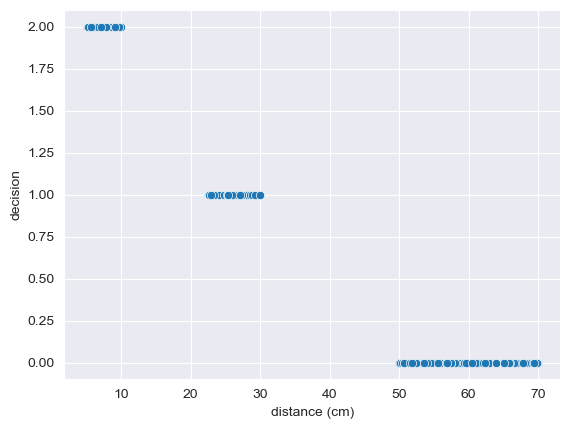

In [12]:
## Target vs distance (cm)
sns.scatterplot(data=df, x=df['distance (cm)'], y=df['decision']);

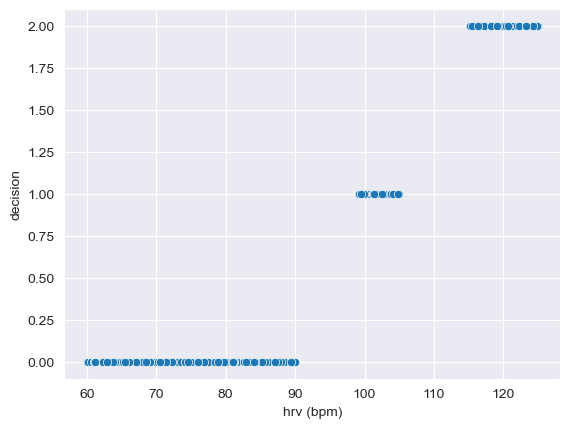

In [13]:
## Target vs hrv (bpm)
sns.scatterplot(data=df, x=df['hrv (bpm)'], y=df['decision']);

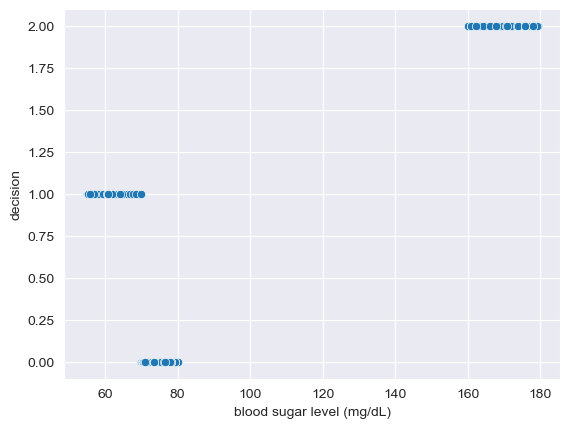

In [14]:
## Target vs blood sugar level (mg/dL)
sns.scatterplot(data=df, x=df['blood sugar level (mg/dL)'], y=df['decision']);

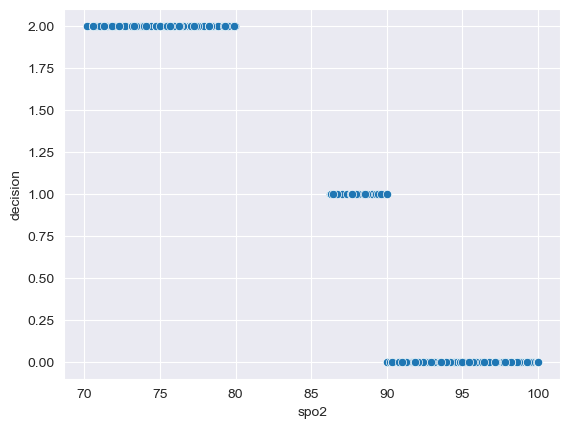

In [15]:
## Target vs spo2
sns.scatterplot(data=df, x=df['spo2'], y=df['decision']);

In [135]:
cols = df[['hrv (bpm)','blood sugar level (mg/dL)','spo2']]
plt.figure(3,1, figsize=(10,8))
for i, variable in enumerate(cols):
                     plt.subplot(2,3,i+1)
                     sns.boxplot(x=df["decision"],y=df[variable],palette="rocket")
                     plt.tight_layout()
                     plt.title(variable)
plt.show();

TypeError: figure() got multiple values for argument 'figsize'

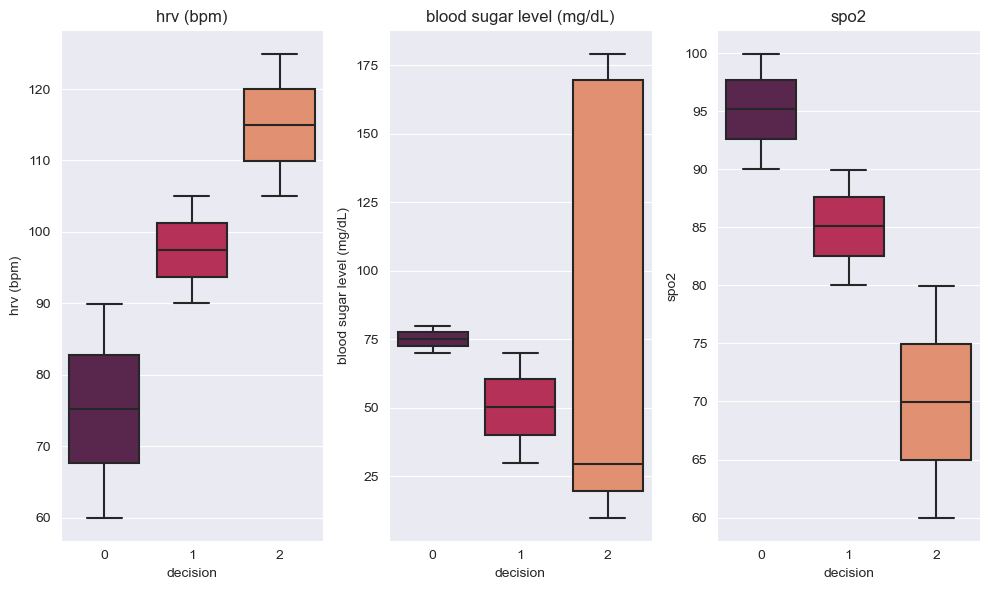

In [147]:
## Subplots configuration
fig, ax = plt.subplots(1,3, figsize=(10,6))

## 
if not isinstance(ax, np.ndarray):
    ax = [ax]

for ax, col in zip(ax, cols):
    sns.boxplot(x=df["decision"], y=df[col], palette="rocket", ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show();

# Multivariate

C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

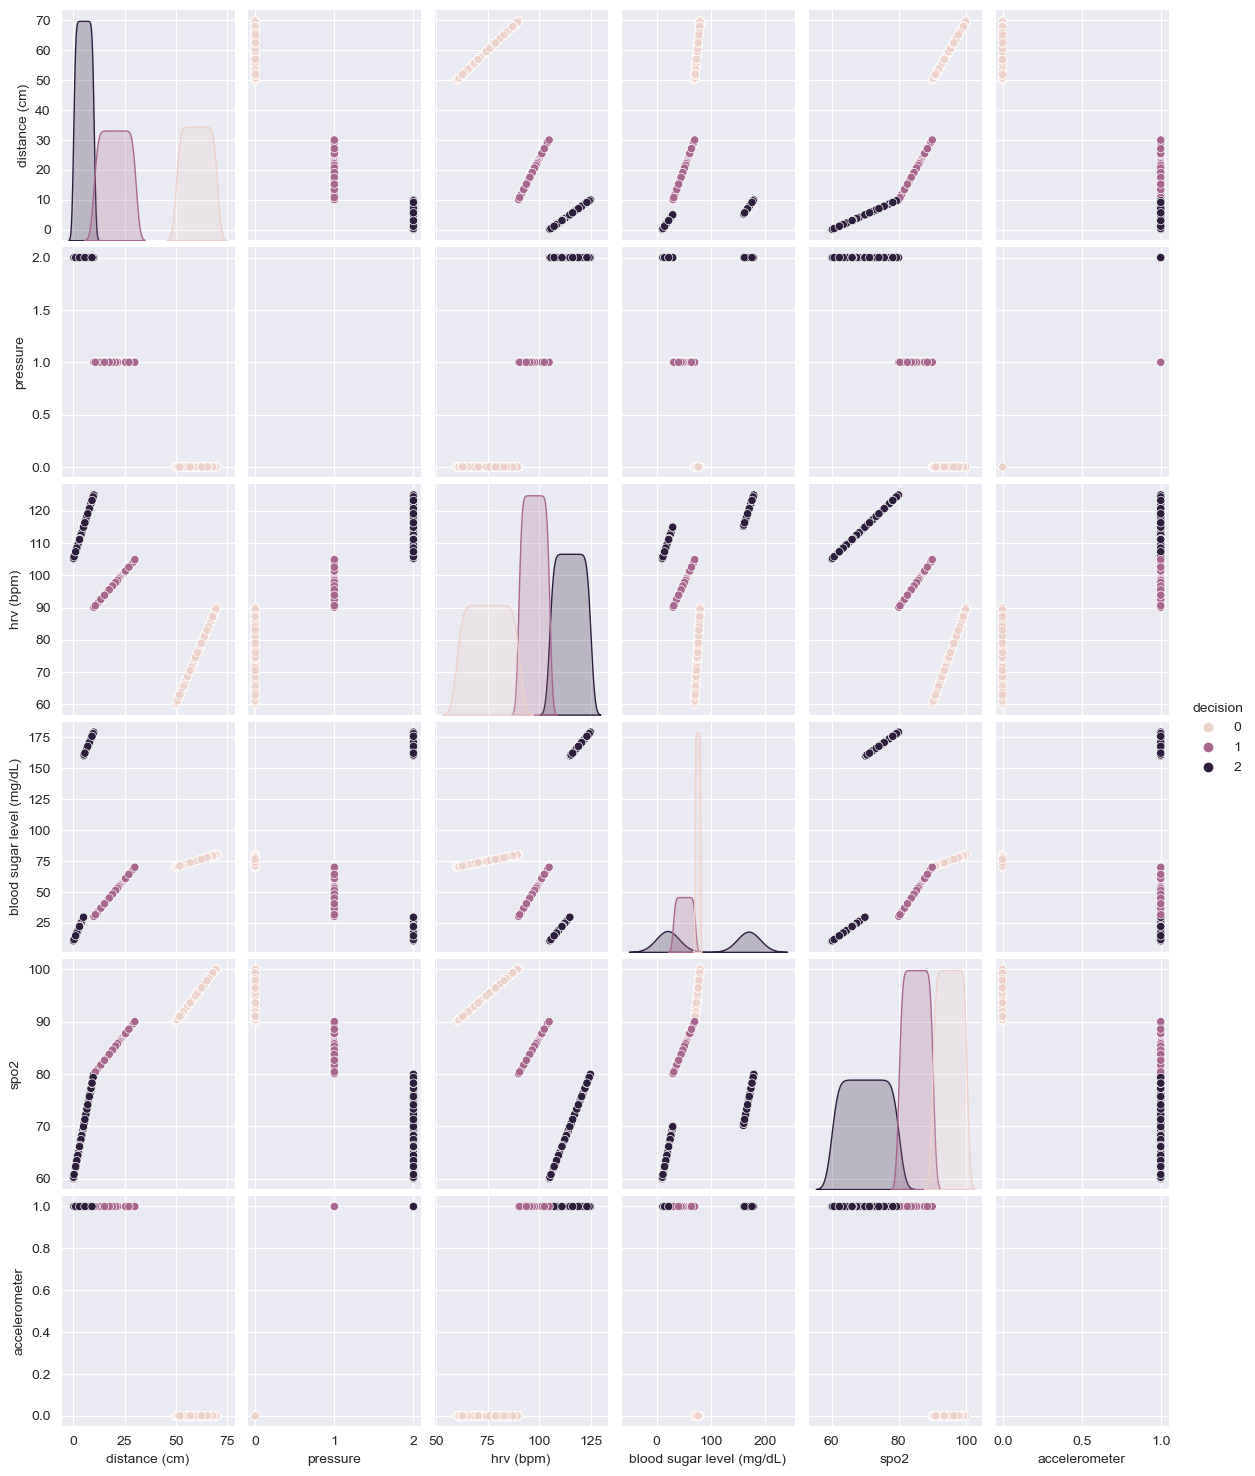

In [102]:
sns.pairplot(data=df, hue='decision', height=2.5, aspect=.8);